# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 20/05/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [6]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

In [7]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
IMG_SIZE = 32
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
TIMESTEPS = 500
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Dataset

- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


2024-05-26 14:21:12.624476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


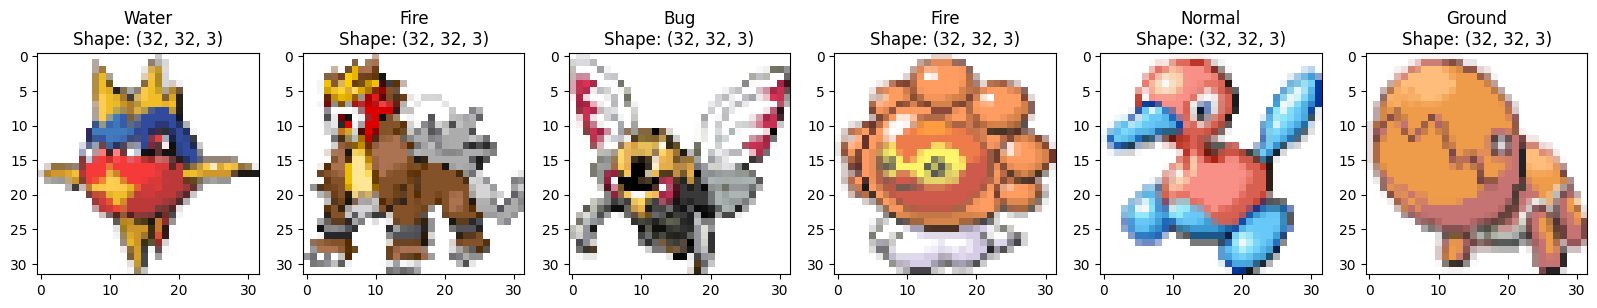

2024-05-26 14:21:13.173550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [10]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, "linear"
)

# wasserstein_loss = WassersteinLoss()

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

## 2.1. Training

Epoch 1/500


I0000 00:00:1716733285.699437   87900 service.cc:145] XLA service 0x71a6340021b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716733285.699462   87900 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-26 14:21:26.068338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1716733286.584469   87900 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-05-26 14:21:27.443555: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-05-26 14:21:33.064367: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations

 1/63 ━━━━━━━━━━━━━━━━━━━━ 27:25 27s/step - accuracy: 0.3235 - loss: 2.3080

I0000 00:00:1716733301.421023   87900 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.5167 - loss: 1.0354
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7952 - loss: 0.2718
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8407 - loss: 0.1976
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8561 - loss: 0.1835
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8709 - loss: 0.1598
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8784 - loss: 0.1496
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8857 - loss: 0.1333
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8908 - loss: 0.1289
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8987 - loss: 0.1158
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8993 - loss: 0.1181
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9052 - loss: 0.1099
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy

Sampling sprite...: 100%|██████████| 500/500 [00:45<00:00, 11.07it/s]


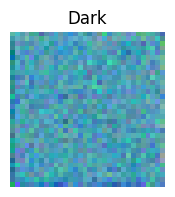

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 834ms/step - accuracy: 0.9231 - loss: 0.0894
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9216 - loss: 0.0926
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9231 - loss: 0.0899
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9256 - loss: 0.0867
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9257 - loss: 0.0875
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9280 - loss: 0.0834
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9281 - loss: 0.0829
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9292 - loss: 0.0819
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9298 - loss: 0.0814
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9295 - loss: 0.0831
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9332 - loss: 0.0769
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step -

Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.33it/s]


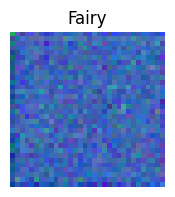

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 817ms/step - accuracy: 0.9388 - loss: 0.0707
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9369 - loss: 0.0753
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9349 - loss: 0.0794
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9389 - loss: 0.0721
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9381 - loss: 0.0741
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9364 - loss: 0.0781
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9410 - loss: 0.0685
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9359 - loss: 0.0793
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9397 - loss: 0.0718
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9373 - loss: 0.0771
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9396 - loss: 0.0730
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step -

Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.33it/s]


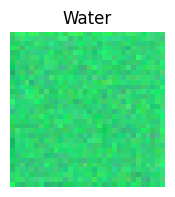

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 818ms/step - accuracy: 0.9427 - loss: 0.0699
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9420 - loss: 0.0710
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9404 - loss: 0.0740
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9417 - loss: 0.0714
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9411 - loss: 0.0735
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9406 - loss: 0.0749
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9437 - loss: 0.0697
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9425 - loss: 0.0706
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9428 - loss: 0.0702
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9445 - loss: 0.0673
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9438 - loss: 0.0698
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step -

Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.23it/s]


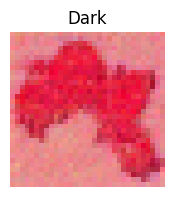

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 824ms/step - accuracy: 0.9437 - loss: 0.0709
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9448 - loss: 0.0686
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9461 - loss: 0.0665
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9450 - loss: 0.0685
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9453 - loss: 0.0668
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9469 - loss: 0.0655
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9449 - loss: 0.0697
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9461 - loss: 0.0664
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9444 - loss: 0.0702
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9480 - loss: 0.0637
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9437 - loss: 0.0710
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step -

Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.34it/s]


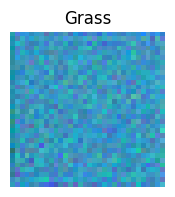

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 817ms/step - accuracy: 0.9466 - loss: 0.0670
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9461 - loss: 0.0673
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9465 - loss: 0.0673
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9479 - loss: 0.0648
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9480 - loss: 0.0651
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9456 - loss: 0.0695
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9478 - loss: 0.0653
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9490 - loss: 0.0632
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9488 - loss: 0.0635
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9474 - loss: 0.0669
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9473 - loss: 0.0674
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.28it/s]


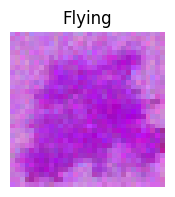

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 821ms/step - accuracy: 0.9487 - loss: 0.0644
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9464 - loss: 0.0694
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9468 - loss: 0.0682
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9490 - loss: 0.0646
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9484 - loss: 0.0659
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9487 - loss: 0.0658
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9491 - loss: 0.0642
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9499 - loss: 0.0632
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9493 - loss: 0.0640
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9501 - loss: 0.0636
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9480 - loss: 0.0676
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.38it/s]


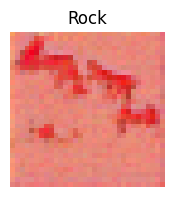

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 814ms/step - accuracy: 0.9507 - loss: 0.0614
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9514 - loss: 0.0622
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9503 - loss: 0.0625
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9510 - loss: 0.0628
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9525 - loss: 0.0591
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9492 - loss: 0.0651
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9520 - loss: 0.0608
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9509 - loss: 0.0620
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9512 - loss: 0.0628
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9513 - loss: 0.0629
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9539 - loss: 0.0570
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


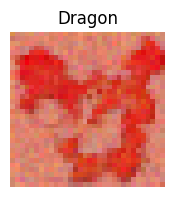

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.9524 - loss: 0.0601
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9513 - loss: 0.0630
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9524 - loss: 0.0605
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9491 - loss: 0.0667
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9538 - loss: 0.0583
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9524 - loss: 0.0610
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9528 - loss: 0.0598
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9533 - loss: 0.0592
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9517 - loss: 0.0623
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9505 - loss: 0.0650
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9513 - loss: 0.0631
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.39it/s]


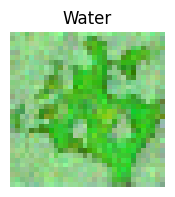

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 814ms/step - accuracy: 0.9503 - loss: 0.0662
Epoch 181/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9522 - loss: 0.0623
Epoch 182/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9528 - loss: 0.0601
Epoch 183/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9516 - loss: 0.0644
Epoch 184/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9540 - loss: 0.0583
Epoch 185/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9525 - loss: 0.0615
Epoch 186/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9540 - loss: 0.0580
Epoch 187/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9537 - loss: 0.0597
Epoch 188/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9508 - loss: 0.0638
Epoch 189/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9543 - loss: 0.0589
Epoch 190/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9532 - loss: 0.0602
Epoch 191/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.43it/s]


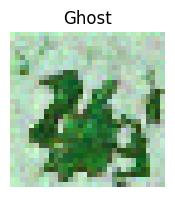

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 811ms/step - accuracy: 0.9547 - loss: 0.0586
Epoch 201/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9529 - loss: 0.0618
Epoch 202/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9533 - loss: 0.0606
Epoch 203/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9550 - loss: 0.0575
Epoch 204/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9533 - loss: 0.0612
Epoch 205/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9531 - loss: 0.0608
Epoch 206/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9540 - loss: 0.0593
Epoch 207/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9538 - loss: 0.0595
Epoch 208/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9508 - loss: 0.0664
Epoch 209/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9524 - loss: 0.0643
Epoch 210/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9537 - loss: 0.0607
Epoch 211/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


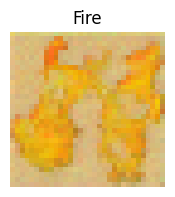

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.9546 - loss: 0.0588
Epoch 221/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9568 - loss: 0.0560
Epoch 222/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9560 - loss: 0.0565
Epoch 223/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9555 - loss: 0.0578
Epoch 224/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9552 - loss: 0.0587
Epoch 225/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9562 - loss: 0.0560
Epoch 226/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9542 - loss: 0.0605
Epoch 227/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9544 - loss: 0.0594
Epoch 228/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9541 - loss: 0.0608
Epoch 229/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9526 - loss: 0.0636
Epoch 230/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9554 - loss: 0.0586
Epoch 231/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


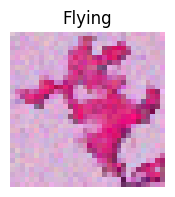

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.9560 - loss: 0.0571
Epoch 241/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9547 - loss: 0.0601
Epoch 242/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9554 - loss: 0.0595
Epoch 243/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9539 - loss: 0.0613
Epoch 244/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9562 - loss: 0.0578
Epoch 245/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9565 - loss: 0.0561
Epoch 246/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9550 - loss: 0.0609
Epoch 247/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9550 - loss: 0.0595
Epoch 248/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9543 - loss: 0.0613
Epoch 249/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9556 - loss: 0.0582
Epoch 250/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9553 - loss: 0.0590
Epoch 251/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


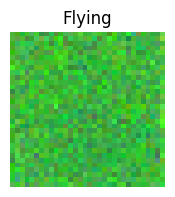

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.9544 - loss: 0.0615
Epoch 261/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9553 - loss: 0.0605
Epoch 262/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9548 - loss: 0.0606
Epoch 263/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9578 - loss: 0.0560
Epoch 264/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9555 - loss: 0.0586
Epoch 265/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9561 - loss: 0.0578
Epoch 266/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9564 - loss: 0.0583
Epoch 267/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9570 - loss: 0.0572
Epoch 268/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9570 - loss: 0.0564
Epoch 269/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9561 - loss: 0.0592
Epoch 270/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9556 - loss: 0.0604
Epoch 271/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.28it/s]


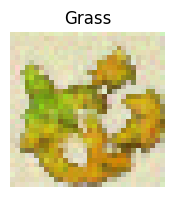

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 821ms/step - accuracy: 0.9559 - loss: 0.0592
Epoch 281/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9556 - loss: 0.0600
Epoch 282/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9545 - loss: 0.0609
Epoch 283/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9571 - loss: 0.0574
Epoch 284/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9569 - loss: 0.0579
Epoch 285/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9573 - loss: 0.0570
Epoch 286/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9570 - loss: 0.0583
Epoch 287/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9554 - loss: 0.0611
Epoch 288/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9578 - loss: 0.0558
Epoch 289/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9569 - loss: 0.0580
Epoch 290/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9563 - loss: 0.0587
Epoch 291/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.39it/s]


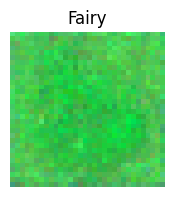

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 814ms/step - accuracy: 0.9568 - loss: 0.0583
Epoch 301/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9594 - loss: 0.0535
Epoch 302/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9573 - loss: 0.0576
Epoch 303/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9573 - loss: 0.0566
Epoch 304/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9587 - loss: 0.0552
Epoch 305/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9577 - loss: 0.0569
Epoch 306/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9585 - loss: 0.0549
Epoch 307/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9568 - loss: 0.0588
Epoch 308/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9582 - loss: 0.0557
Epoch 309/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9581 - loss: 0.0560
Epoch 310/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9579 - loss: 0.0572
Epoch 311/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.38it/s]


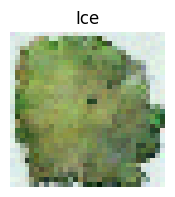

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 814ms/step - accuracy: 0.9582 - loss: 0.0561
Epoch 321/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9597 - loss: 0.0540
Epoch 322/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9580 - loss: 0.0569
Epoch 323/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9569 - loss: 0.0590
Epoch 324/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9573 - loss: 0.0567
Epoch 325/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9581 - loss: 0.0558
Epoch 326/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9586 - loss: 0.0557
Epoch 327/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9562 - loss: 0.0609
Epoch 328/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9571 - loss: 0.0577
Epoch 329/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9580 - loss: 0.0571
Epoch 330/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9578 - loss: 0.0579
Epoch 331/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.37it/s]


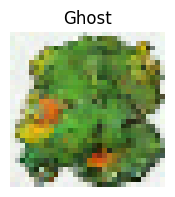

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 815ms/step - accuracy: 0.9576 - loss: 0.0573
Epoch 341/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9587 - loss: 0.0558
Epoch 342/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9597 - loss: 0.0535
Epoch 343/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9579 - loss: 0.0579
Epoch 344/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9607 - loss: 0.0523
Epoch 345/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9587 - loss: 0.0553
Epoch 346/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9591 - loss: 0.0554
Epoch 347/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9589 - loss: 0.0551
Epoch 348/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9592 - loss: 0.0552
Epoch 349/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9571 - loss: 0.0590
Epoch 350/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9580 - loss: 0.0564
Epoch 351/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:43<00:00, 11.42it/s]


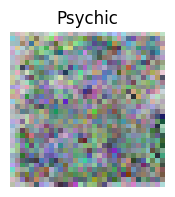

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 812ms/step - accuracy: 0.9593 - loss: 0.0540
Epoch 361/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9590 - loss: 0.0551
Epoch 362/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9573 - loss: 0.0594
Epoch 363/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9586 - loss: 0.0558
Epoch 364/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9584 - loss: 0.0571
Epoch 365/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9589 - loss: 0.0556
Epoch 366/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9576 - loss: 0.0584
Epoch 367/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9586 - loss: 0.0566
Epoch 368/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9582 - loss: 0.0572
Epoch 369/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9573 - loss: 0.0587
Epoch 370/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9588 - loss: 0.0554
Epoch 371/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.33it/s]


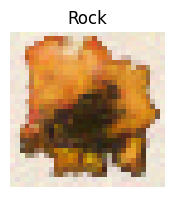

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 817ms/step - accuracy: 0.9587 - loss: 0.0564
Epoch 381/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9567 - loss: 0.0600
Epoch 382/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9585 - loss: 0.0575
Epoch 383/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9580 - loss: 0.0583
Epoch 384/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9586 - loss: 0.0563
Epoch 385/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9604 - loss: 0.0529
Epoch 386/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9604 - loss: 0.0538
Epoch 387/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9606 - loss: 0.0535
Epoch 388/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9601 - loss: 0.0544
Epoch 389/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9595 - loss: 0.0548
Epoch 390/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9585 - loss: 0.0565
Epoch 391/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.43it/s]


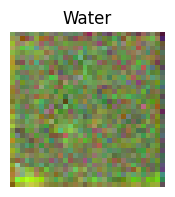

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 879ms/step - accuracy: 0.9598 - loss: 0.0542
Epoch 401/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9610 - loss: 0.0521
Epoch 402/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9579 - loss: 0.0583
Epoch 403/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9606 - loss: 0.0532
Epoch 404/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9602 - loss: 0.0545
Epoch 405/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9602 - loss: 0.0543
Epoch 406/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9592 - loss: 0.0562
Epoch 407/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9595 - loss: 0.0551
Epoch 408/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9590 - loss: 0.0565
Epoch 409/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9589 - loss: 0.0568
Epoch 410/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9595 - loss: 0.0552
Epoch 411/500
63/63 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:46<00:00, 10.69it/s]


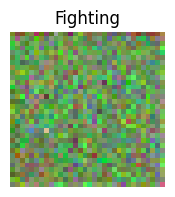

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 863ms/step - accuracy: 0.9596 - loss: 0.0551
Epoch 421/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9603 - loss: 0.0542
Epoch 422/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9596 - loss: 0.0555
Epoch 423/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9620 - loss: 0.0518
Epoch 424/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9594 - loss: 0.0564
Epoch 425/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9594 - loss: 0.0567
Epoch 426/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9590 - loss: 0.0571
Epoch 427/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9622 - loss: 0.0513
Epoch 428/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9594 - loss: 0.0564
Epoch 429/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9608 - loss: 0.0533
Epoch 430/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9615 - loss: 0.0524
Epoch 431/500
63/63 ━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


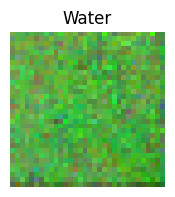

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 873ms/step - accuracy: 0.9612 - loss: 0.0528
Epoch 441/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9599 - loss: 0.0545
Epoch 442/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9604 - loss: 0.0554
Epoch 443/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9608 - loss: 0.0535
Epoch 444/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9607 - loss: 0.0530
Epoch 445/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9603 - loss: 0.0536
Epoch 446/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9589 - loss: 0.0574
Epoch 447/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9626 - loss: 0.0503
Epoch 448/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9609 - loss: 0.0541
Epoch 449/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9619 - loss: 0.0517
Epoch 450/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9612 - loss: 0.0525
Epoch 451/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


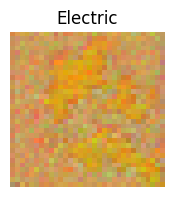

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 875ms/step - accuracy: 0.9592 - loss: 0.0572
Epoch 461/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9614 - loss: 0.0530
Epoch 462/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9596 - loss: 0.0547
Epoch 463/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9619 - loss: 0.0514
Epoch 464/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9613 - loss: 0.0529
Epoch 465/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9603 - loss: 0.0554
Epoch 466/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9598 - loss: 0.0558
Epoch 467/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9599 - loss: 0.0557
Epoch 468/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9589 - loss: 0.0571
Epoch 469/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9621 - loss: 0.0508
Epoch 470/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9607 - loss: 0.0526
Epoch 471/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


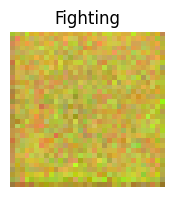

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 878ms/step - accuracy: 0.9616 - loss: 0.0526
Epoch 481/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9601 - loss: 0.0552
Epoch 482/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9616 - loss: 0.0519
Epoch 483/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9591 - loss: 0.0573
Epoch 484/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9594 - loss: 0.0554
Epoch 485/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9622 - loss: 0.0519
Epoch 486/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9620 - loss: 0.0521
Epoch 487/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9612 - loss: 0.0541
Epoch 488/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9599 - loss: 0.0565
Epoch 489/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9611 - loss: 0.0532
Epoch 490/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9597 - loss: 0.0563
Epoch 491/500
63/63 ━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


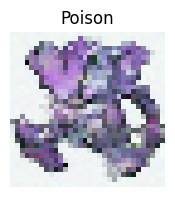

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 890ms/step - accuracy: 0.9622 - loss: 0.0514


In [11]:
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/6


Sampling sprite...: 100%|██████████| 500/500 [00:45<00:00, 11.03it/s]


Generating sample 2/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.35it/s]


Generating sample 3/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.32it/s]


Generating sample 4/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.36it/s]


Generating sample 5/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.35it/s]


Generating sample 6/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.25it/s]


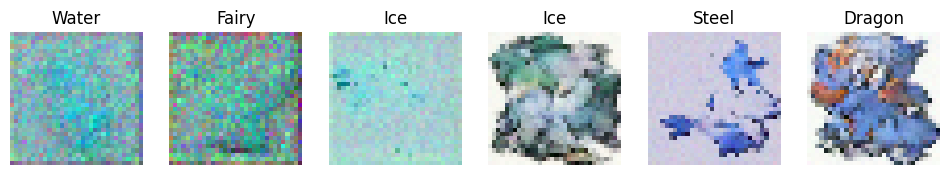

In [12]:
# Sample some sprites
# =====================================================================
model.plot_samples(6)

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9631 - loss: 0.0504
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9607 - loss: 0.0545
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9605 - loss: 0.0539
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9608 - loss: 0.0543
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9614 - loss: 0.0529
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9610 - loss: 0.0533
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9611 - loss: 0.0550
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9610 - loss: 0.0538
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9620 - loss: 0.0520
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9628 - loss: 0.0514
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9596 - loss: 0.0557
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms

Sampling sprite...: 100%|██████████| 500/500 [00:46<00:00, 10.80it/s]


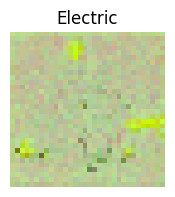

63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 855ms/step - accuracy: 0.9619 - loss: 0.0520
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9616 - loss: 0.0534
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9620 - loss: 0.0522
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9616 - loss: 0.0539
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9595 - loss: 0.0561
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9613 - loss: 0.0538
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9620 - loss: 0.0522
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9622 - loss: 0.0522
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9617 - loss: 0.0530
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9603 - loss: 0.0557
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9625 - loss: 0.0515
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms

Sampling sprite...: 100%|██████████| 500/500 [00:46<00:00, 10.70it/s]


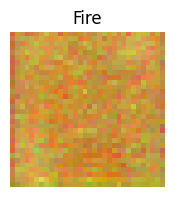

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 864ms/step - accuracy: 0.9604 - loss: 0.0549
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9631 - loss: 0.0490
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9625 - loss: 0.0521
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9607 - loss: 0.0553
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9604 - loss: 0.0534
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9630 - loss: 0.0504
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9640 - loss: 0.0486
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9618 - loss: 0.0525
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9613 - loss: 0.0532
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9608 - loss: 0.0540
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9626 - loss: 0.0512
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103m

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.56it/s]


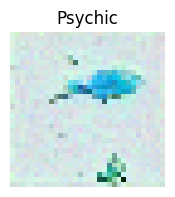

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 874ms/step - accuracy: 0.9634 - loss: 0.0508
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9650 - loss: 0.0468
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9620 - loss: 0.0518
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9625 - loss: 0.0514
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9626 - loss: 0.0519
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9609 - loss: 0.0554
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9603 - loss: 0.0550
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9620 - loss: 0.0521
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9611 - loss: 0.0534
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9649 - loss: 0.0474
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9612 - loss: 0.0547
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.63it/s]


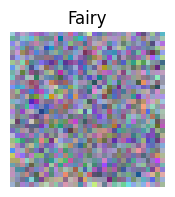

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 871ms/step - accuracy: 0.9626 - loss: 0.0518
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9621 - loss: 0.0531
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9622 - loss: 0.0506
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9609 - loss: 0.0542
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9604 - loss: 0.0549
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9627 - loss: 0.0511
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9646 - loss: 0.0481
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9621 - loss: 0.0521
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9623 - loss: 0.0518
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9618 - loss: 0.0533
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9624 - loss: 0.0518
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103

Sampling sprite...: 100%|██████████| 500/500 [00:46<00:00, 10.65it/s]


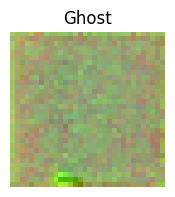

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 867ms/step - accuracy: 0.9633 - loss: 0.0505
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9620 - loss: 0.0532
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9615 - loss: 0.0534
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9628 - loss: 0.0521
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9634 - loss: 0.0497
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9626 - loss: 0.0512
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9622 - loss: 0.0531
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9609 - loss: 0.0538
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9644 - loss: 0.0480
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9629 - loss: 0.0513
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9641 - loss: 0.0504
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.42it/s]


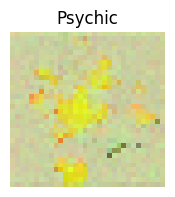

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 889ms/step - accuracy: 0.9615 - loss: 0.0543
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9622 - loss: 0.0525
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9630 - loss: 0.0506
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9640 - loss: 0.0489
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9648 - loss: 0.0488
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9615 - loss: 0.0532
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9625 - loss: 0.0517
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9608 - loss: 0.0553
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9629 - loss: 0.0516
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9653 - loss: 0.0468
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9616 - loss: 0.0535
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.46it/s]


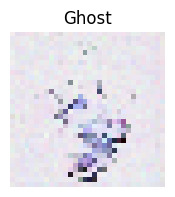

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 885ms/step - accuracy: 0.9634 - loss: 0.0497
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9630 - loss: 0.0516
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9643 - loss: 0.0495
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9624 - loss: 0.0519
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9621 - loss: 0.0523
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9621 - loss: 0.0523
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9606 - loss: 0.0564
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9629 - loss: 0.0516
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9627 - loss: 0.0515
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9629 - loss: 0.0507
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9620 - loss: 0.0531
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.42it/s]


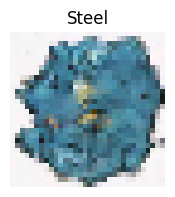

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 887ms/step - accuracy: 0.9623 - loss: 0.0528
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9638 - loss: 0.0499
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9639 - loss: 0.0494
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9619 - loss: 0.0536
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9626 - loss: 0.0522
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9624 - loss: 0.0519
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9643 - loss: 0.0487
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9643 - loss: 0.0499
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9631 - loss: 0.0510
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9639 - loss: 0.0497
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9647 - loss: 0.0478
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:48<00:00, 10.31it/s]


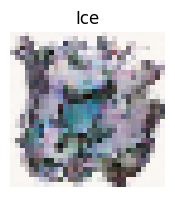

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 896ms/step - accuracy: 0.9627 - loss: 0.0520
Epoch 181/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9624 - loss: 0.0526
Epoch 182/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9630 - loss: 0.0516
Epoch 183/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9633 - loss: 0.0513
Epoch 184/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9649 - loss: 0.0479
Epoch 185/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9614 - loss: 0.0541
Epoch 186/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9632 - loss: 0.0511
Epoch 187/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9638 - loss: 0.0495
Epoch 188/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9656 - loss: 0.0473
Epoch 189/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9646 - loss: 0.0489
Epoch 190/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9632 - loss: 0.0509
Epoch 191/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:50<00:00,  9.93it/s]


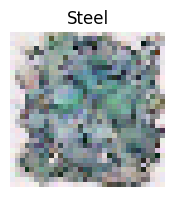

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 928ms/step - accuracy: 0.9636 - loss: 0.0503
Epoch 201/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9636 - loss: 0.0504
Epoch 202/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9639 - loss: 0.0493
Epoch 203/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9629 - loss: 0.0511
Epoch 204/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9631 - loss: 0.0515
Epoch 205/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9637 - loss: 0.0507
Epoch 206/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9630 - loss: 0.0520
Epoch 207/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9637 - loss: 0.0510
Epoch 208/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9621 - loss: 0.0529
Epoch 209/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9649 - loss: 0.0480
Epoch 210/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9632 - loss: 0.0510
Epoch 211/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:51<00:00,  9.77it/s]


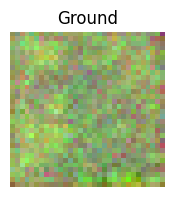

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 940ms/step - accuracy: 0.9659 - loss: 0.0469
Epoch 221/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9619 - loss: 0.0529
Epoch 222/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9633 - loss: 0.0503
Epoch 223/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9636 - loss: 0.0498
Epoch 224/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9641 - loss: 0.0497
Epoch 225/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9643 - loss: 0.0493
Epoch 226/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9640 - loss: 0.0498
Epoch 227/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9623 - loss: 0.0513
Epoch 228/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9656 - loss: 0.0464
Epoch 229/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9647 - loss: 0.0483
Epoch 230/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9645 - loss: 0.0484
Epoch 231/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:50<00:00,  9.93it/s]


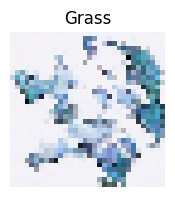

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 931ms/step - accuracy: 0.9630 - loss: 0.0522
Epoch 241/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9626 - loss: 0.0523
Epoch 242/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9618 - loss: 0.0530
Epoch 243/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9653 - loss: 0.0481
Epoch 244/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9617 - loss: 0.0520
Epoch 245/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9644 - loss: 0.0486
Epoch 246/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9646 - loss: 0.0486
Epoch 247/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9633 - loss: 0.0511
Epoch 248/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9654 - loss: 0.0473
Epoch 249/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9635 - loss: 0.0517
Epoch 250/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9629 - loss: 0.0517
Epoch 251/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.50it/s]


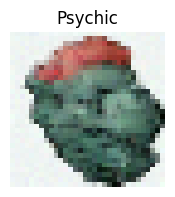

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 883ms/step - accuracy: 0.9638 - loss: 0.0499
Epoch 261/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9652 - loss: 0.0480
Epoch 262/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9631 - loss: 0.0515
Epoch 263/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9636 - loss: 0.0514
Epoch 264/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9640 - loss: 0.0512
Epoch 265/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9640 - loss: 0.0502
Epoch 266/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9646 - loss: 0.0483
Epoch 267/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9640 - loss: 0.0499
Epoch 268/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9649 - loss: 0.0474
Epoch 269/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9630 - loss: 0.0518
Epoch 270/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9641 - loss: 0.0499
Epoch 271/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.52it/s]


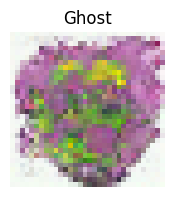

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 881ms/step - accuracy: 0.9646 - loss: 0.0476
Epoch 281/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9622 - loss: 0.0526
Epoch 282/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9623 - loss: 0.0520
Epoch 283/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9652 - loss: 0.0482
Epoch 284/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9645 - loss: 0.0489
Epoch 285/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9634 - loss: 0.0502
Epoch 286/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9636 - loss: 0.0510
Epoch 287/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9645 - loss: 0.0493
Epoch 288/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9648 - loss: 0.0491
Epoch 289/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9639 - loss: 0.0498
Epoch 290/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9638 - loss: 0.0501
Epoch 291/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.43it/s]


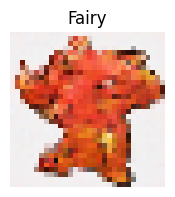

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 887ms/step - accuracy: 0.9614 - loss: 0.0548
Epoch 301/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9629 - loss: 0.0519
Epoch 302/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9659 - loss: 0.0461
Epoch 303/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9633 - loss: 0.0514
Epoch 304/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9643 - loss: 0.0491
Epoch 305/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9660 - loss: 0.0462
Epoch 306/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9656 - loss: 0.0478
Epoch 307/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9639 - loss: 0.0501
Epoch 308/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9632 - loss: 0.0513
Epoch 309/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9645 - loss: 0.0490
Epoch 310/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9640 - loss: 0.0497
Epoch 311/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.47it/s]


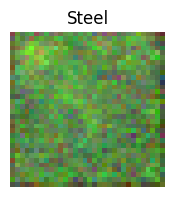

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 882ms/step - accuracy: 0.9644 - loss: 0.0497
Epoch 321/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9633 - loss: 0.0509
Epoch 322/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9632 - loss: 0.0521
Epoch 323/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9643 - loss: 0.0491
Epoch 324/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9645 - loss: 0.0497
Epoch 325/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9646 - loss: 0.0496
Epoch 326/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9627 - loss: 0.0524
Epoch 327/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9655 - loss: 0.0470
Epoch 328/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9641 - loss: 0.0504
Epoch 329/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9646 - loss: 0.0485
Epoch 330/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9648 - loss: 0.0487
Epoch 331/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.51it/s]


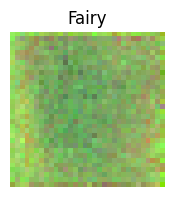

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 881ms/step - accuracy: 0.9657 - loss: 0.0477
Epoch 341/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9658 - loss: 0.0477
Epoch 342/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9649 - loss: 0.0486
Epoch 343/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9650 - loss: 0.0487
Epoch 344/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9643 - loss: 0.0497
Epoch 345/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9653 - loss: 0.0477
Epoch 346/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9658 - loss: 0.0470
Epoch 347/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9647 - loss: 0.0484
Epoch 348/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9643 - loss: 0.0499
Epoch 349/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9648 - loss: 0.0489
Epoch 350/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9644 - loss: 0.0492
Epoch 351/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.50it/s]


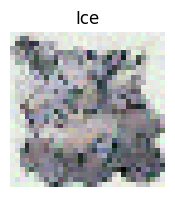

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 882ms/step - accuracy: 0.9648 - loss: 0.0491
Epoch 361/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9638 - loss: 0.0498
Epoch 362/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9636 - loss: 0.0496
Epoch 363/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9640 - loss: 0.0485
Epoch 364/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9651 - loss: 0.0486
Epoch 365/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9646 - loss: 0.0490
Epoch 366/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9654 - loss: 0.0475
Epoch 367/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9644 - loss: 0.0493
Epoch 368/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9645 - loss: 0.0492
Epoch 369/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9653 - loss: 0.0481
Epoch 370/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9642 - loss: 0.0491
Epoch 371/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.49it/s]


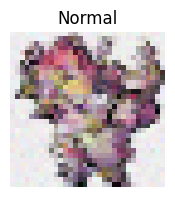

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 882ms/step - accuracy: 0.9655 - loss: 0.0474
Epoch 381/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9648 - loss: 0.0486
Epoch 382/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9627 - loss: 0.0521
Epoch 383/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9647 - loss: 0.0490
Epoch 384/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9647 - loss: 0.0494
Epoch 385/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9659 - loss: 0.0470
Epoch 386/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9652 - loss: 0.0477
Epoch 387/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9638 - loss: 0.0500
Epoch 388/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9644 - loss: 0.0493
Epoch 389/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9650 - loss: 0.0482
Epoch 390/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9663 - loss: 0.0464
Epoch 391/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.47it/s]


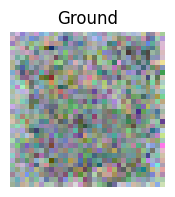

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 884ms/step - accuracy: 0.9645 - loss: 0.0496
Epoch 401/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9648 - loss: 0.0487
Epoch 402/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9634 - loss: 0.0507
Epoch 403/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9646 - loss: 0.0491
Epoch 404/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9664 - loss: 0.0456
Epoch 405/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9663 - loss: 0.0467
Epoch 406/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9653 - loss: 0.0482
Epoch 407/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9665 - loss: 0.0461
Epoch 408/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9650 - loss: 0.0483
Epoch 409/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9657 - loss: 0.0469
Epoch 410/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9646 - loss: 0.0497
Epoch 411/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.49it/s]


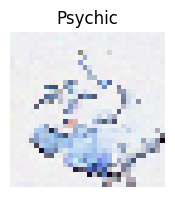

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 883ms/step - accuracy: 0.9652 - loss: 0.0479
Epoch 421/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9654 - loss: 0.0476
Epoch 422/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9649 - loss: 0.0485
Epoch 423/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9663 - loss: 0.0467
Epoch 424/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9655 - loss: 0.0478
Epoch 425/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9631 - loss: 0.0524
Epoch 426/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9660 - loss: 0.0473
Epoch 427/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9652 - loss: 0.0484
Epoch 428/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9641 - loss: 0.0508
Epoch 429/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9650 - loss: 0.0483
Epoch 430/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9652 - loss: 0.0471
Epoch 431/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.51it/s]


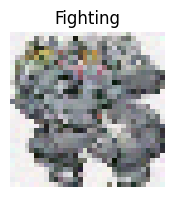

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 881ms/step - accuracy: 0.9642 - loss: 0.0494
Epoch 441/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9648 - loss: 0.0484
Epoch 442/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9657 - loss: 0.0468
Epoch 443/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9665 - loss: 0.0459
Epoch 444/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9638 - loss: 0.0510
Epoch 445/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9658 - loss: 0.0475
Epoch 446/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9639 - loss: 0.0513
Epoch 447/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9644 - loss: 0.0499
Epoch 448/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9658 - loss: 0.0476
Epoch 449/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9642 - loss: 0.0497
Epoch 450/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9662 - loss: 0.0464
Epoch 451/500
63/63 ━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


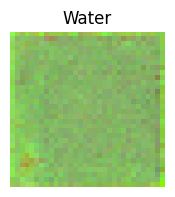

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 879ms/step - accuracy: 0.9659 - loss: 0.0465
Epoch 461/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9652 - loss: 0.0484
Epoch 462/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9656 - loss: 0.0468
Epoch 463/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9664 - loss: 0.0464
Epoch 464/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9655 - loss: 0.0481
Epoch 465/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9659 - loss: 0.0474
Epoch 466/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9648 - loss: 0.0483
Epoch 467/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9633 - loss: 0.0513
Epoch 468/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9627 - loss: 0.0520
Epoch 469/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9669 - loss: 0.0449
Epoch 470/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9667 - loss: 0.0457
Epoch 471/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.52it/s]


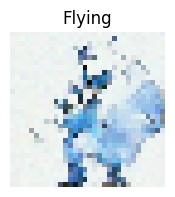

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 880ms/step - accuracy: 0.9662 - loss: 0.0443
Epoch 481/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9657 - loss: 0.0469
Epoch 482/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9651 - loss: 0.0473
Epoch 483/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9654 - loss: 0.0472
Epoch 484/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9637 - loss: 0.0499
Epoch 485/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9654 - loss: 0.0476
Epoch 486/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9647 - loss: 0.0483
Epoch 487/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9656 - loss: 0.0466
Epoch 488/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9662 - loss: 0.0457
Epoch 489/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9671 - loss: 0.0443
Epoch 490/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9662 - loss: 0.0462
Epoch 491/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


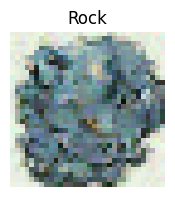

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 880ms/step - accuracy: 0.9664 - loss: 0.0460


In [13]:
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

## 2.2. Results and save model

Generating sample 1/6


Sampling sprite...: 100%|██████████| 500/500 [00:45<00:00, 11.09it/s]


Generating sample 2/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.34it/s]


Generating sample 3/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.32it/s]


Generating sample 4/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.36it/s]


Generating sample 5/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.36it/s]


Generating sample 6/6


Sampling sprite...: 100%|██████████| 500/500 [00:44<00:00, 11.35it/s]


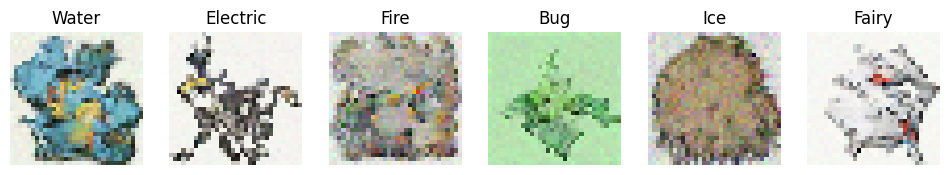

In [14]:
# Sample some sprites
# =====================================================================
model.plot_samples(6)

In [ ]:
# Save the model
# =====================================================================
# model.save(f"{MODELS_PATH}/diffusion_model") TODO: TBC

[BACK TO TOP](#top)